# If you want to download datasets and trained models, go to this [link](https://drive.google.com/drive/folders/1Ltqj8wiuXxrl1p_KzrzfaJkn2EDfI-M4?usp=sharing). Download file named text generation using lstm.zip and unzip it

In [1]:
%config IPCompleter.use_jedi = False

In [2]:
import re
import pickle
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plot

In [3]:
pickle_in = open("plots_text.pickle","rb")
movie_plots = pickle.load(pickle_in)

In [4]:
movie_plots = [re.sub("[^a-z' ]", "", i) for i in movie_plots]

In [5]:
len_arr = []
def count_sent_len(sent):
    sent = sent.split()
    length= len(sent)
    len_arr.append(length)
    return length

for sent in movie_plots:
    count_sent_len(sent)

In [6]:
# count_arr = []
# range = 100
# len_pd = pd.Series(len_arr)
# len_pd.describe()
    

In [7]:
# plot.figure(figsize=(10,6))
# sns.distplot(len_pd, bins=100)

### Instead of padding sentence for LSTM, i split a sentence into many sentence with a same lenght.
### For example: ['i', 'have', 'played', 'football', 'yesterday']
### If i choose seq_len is 3, the sentence will be splited in to 3 senctences
### ['i', 'have', 'played'], ['have', 'played', 'football'], ['played', 'football', 'yesterday']

In [8]:
def create_seq(text, seq_len = 10):
    sequences = []
    if len(text.split()) > seq_len:
        for i in range(seq_len, len(text.split())):
            seq = text.split()[i-seq_len:i+1]
            sequences.append(" ".join(seq))
        return sequences

    else: 
        return [text]

fix_length_seqs = [create_seq(i) for i in movie_plots]
fix_length_seqs = sum(fix_length_seqs, [])

In [9]:
tokenized_movie_plots = [sent.split() for sent in movie_plots]

# Create word2index dictionary for encode sentence

In [10]:
import gensim
from gensim import corpora
word2index = corpora.Dictionary(tokenized_movie_plots)

In [11]:
vocal_size = len(word2index)
vocal_size

16592

In [12]:
count = 0
x = []
y = []
for s in fix_length_seqs:
    if count < 1:
        x.append(" ".join(s.split()[:-1]))
        y.append(" ".join(s.split()[1:]))
print(len(x), len(y))

150144 150144


In [13]:
def encode_sent(sents, seq_len):
    res = np.zeros((len(x), seq_len), dtype = int)
    
    for i, sent in enumerate(sents):
        new = [word2index.token2id[word] for word in sent.split() if word in word2index.token2id.keys()]
        res[i,:] = np.array(new)
    
    return res
X = encode_sent(x, 10)
Y = encode_sent(y, 10)
y = Y
# y = [encode_sent(tok_sent) for tok_sent in y]

# Train test split and batch loader

In [14]:
rate = 0.1/0.9
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=rate, random_state=1) # 0.25 x 0.8 = 0.2

In [15]:
from torch.utils.data import DataLoader, TensorDataset
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [16]:
# dataloaders
batch_size = 50
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [17]:
for x, y  in train_loader:
    print(x.size())
    break
    

torch.Size([50, 10])


# Create LSTM model

In [13]:
class LSTM_Net(nn.Module):
    def __init__(self, embedding_dim, input_size, num_layers, output_size, hidden_dim, p_drop= 0.3):
        super(LSTM_Net, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=0.5, batch_first=True)
        self.dropout = nn.Dropout(p_drop)
        self.fc1 = nn.Linear(hidden_dim, output_size)
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        if (torch.cuda.is_available()):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden
    
    def forward(self, x, h):
        out = self.embedding(x)
        out, h = self.lstm(out, h)
        out = self.dropout(out)
        
        # turn into 2D array for linear layer
        out = out.reshape(-1, self.hidden_dim)
        out = self.fc1(out)
        return out, h

EMBEDDING_DIM = 200
INPUT_SIZE = vocal_size
OUTPUT_SIZE = vocal_size
NUM_LAYERS = 2
HIDDEN_DIM = 256
lstm_model = LSTM_Net(EMBEDDING_DIM, INPUT_SIZE, NUM_LAYERS, OUTPUT_SIZE, HIDDEN_DIM)

if(torch.cuda.is_available()):
    lstm_model = lstm_model.cuda()
lstm_model

LSTM_Net(
  (embedding): Embedding(16592, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=16592, bias=True)
)

# Train model

In [19]:
NUM_EPOCHS = 15
LEARNING_RATE = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)

In [20]:
lstm_model.train()
clip = 5
train_loss_arr = []
val_loss_arr = []
epoch_arr = []
for epoch in range(NUM_EPOCHS):
    running_train_loss = 0
    running_val_loss = 0
    for input, target in train_loader:
        target = target.long()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()
        hidden = lstm_model.init_hidden(input.size(0))
        lstm_model.zero_grad()
        output, hidden = lstm_model(input, hidden)
        
        # make vertial dim of output and target identical
        loss = criterion(output, target.reshape(-1))
        loss.backward()
        nn.utils.clip_grad_norm_(lstm_model.parameters(), clip)
        optimizer.step()
        
        running_train_loss = running_train_loss + loss.item()
        
    lstm_model.eval()
    for input, target in valid_loader:
        target = target.long()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()
        hidden = lstm_model.init_hidden(input.size(0))    
        output, hidden = lstm_model(input, hidden)
        loss = criterion(output, target.reshape(-1))
        running_val_loss = running_val_loss + loss.item()
    
    lstm_model.train()
    train_loss_arr.append(running_train_loss/len(train_loader))
    val_loss_arr.append(running_val_loss/len(valid_loader))
    epoch_arr.append(epoch)
    print("Epoch: {}/{}...".format(epoch+1, NUM_EPOCHS),
                  "Train_Loss: {:.6f}...".format(running_train_loss/len(train_loader)),
                  "Val Loss: {:.6f}".format(running_val_loss/len(valid_loader)))

Epoch: 1/15... Train_Loss: 6.460339... Val Loss: 5.654970
Epoch: 2/15... Train_Loss: 5.359494... Val Loss: 4.763781
Epoch: 3/15... Train_Loss: 4.688918... Val Loss: 4.133925
Epoch: 4/15... Train_Loss: 4.234800... Val Loss: 3.703659
Epoch: 5/15... Train_Loss: 3.919102... Val Loss: 3.388559
Epoch: 6/15... Train_Loss: 3.686544... Val Loss: 3.147874
Epoch: 7/15... Train_Loss: 3.504466... Val Loss: 2.962750
Epoch: 8/15... Train_Loss: 3.358067... Val Loss: 2.803102
Epoch: 9/15... Train_Loss: 3.238171... Val Loss: 2.668222
Epoch: 10/15... Train_Loss: 3.134733... Val Loss: 2.564389
Epoch: 11/15... Train_Loss: 3.043250... Val Loss: 2.463561
Epoch: 12/15... Train_Loss: 2.965045... Val Loss: 2.382879
Epoch: 13/15... Train_Loss: 2.896494... Val Loss: 2.300797
Epoch: 14/15... Train_Loss: 2.834049... Val Loss: 2.240657
Epoch: 15/15... Train_Loss: 2.776650... Val Loss: 2.182260


# Save and load model

In [15]:
PATH = "lstm_textgen_state_dict_model.pt"
# torch.save(lstm_model.state_dict(), PATH)

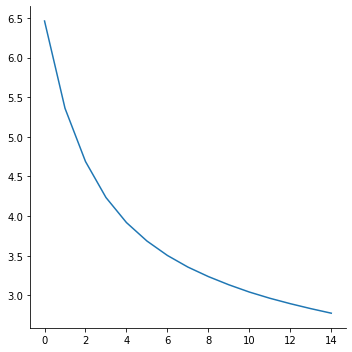

In [23]:
sns.relplot(x=epoch_arr, y=train_loss_arr, kind="line")

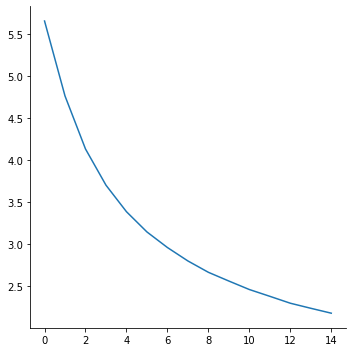

In [24]:
sns.relplot(x=epoch_arr, y=val_loss_arr, kind="line")

In [16]:
load_model = LSTM_Net(EMBEDDING_DIM, INPUT_SIZE, NUM_LAYERS, OUTPUT_SIZE, HIDDEN_DIM)
PATH = "lstm_textgen_state_dict_model.pt"
if(torch.cuda.is_available()):
    load_model = load_model.cuda()
load_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# Test performance of model

In [17]:
def res_encode_sent(sent):
    new = [word2index.token2id[word] for word in sent.split() if word in word2index.token2id.keys()]
    return new
res_encode_sent("it is")

[447, 49]

In [152]:

def predict(net, sent, h=None):
    x = np.array([res_encode_sent(sent)])
    inputs = torch.from_numpy(x)
    
    if(torch.cuda.is_available()):
        inputs = inputs.cuda()
        
    out, h = load_model(inputs, h)
    p = F.softmax(out, dim=1).data
    p = p.cpu()

    p = p.numpy()
    p = p.reshape(-1)
    top_n_idx = p.argsort()[-1:]
#     sampled_token_index = top_n_idx[random.sample([0,1,2],1)[0]]
    word = word2index[top_n_idx[0]]
    return word, h


In [153]:
word2index[376]

'will'

In [158]:
def sample(net, size, sent='it is'):
    net.cuda()

    h = net.init_hidden(1)
    toks = sent.split()
    
    for t in sent.split():
        token, h = predict(load_model, t, h)
    
    toks.append(token)
    
    for i in range(size-1):
        token, h = predict(load_model, toks[-1], h)
        toks.append(token)
    
    return ' '.join(toks)

sample(load_model,15, "i fuck")


    

'i fuck out of the house and he discovers the digital watch he had vowed once in'